# MRI QC Report

**Author**: Haroon Popal

This notebook will create the **participants.tsv** file in the BIDS format which will include the subject ID and demographic information for all participants with fmriprep data. The notebook will also create a second list of participants and their run data, **participants_good_SR.csv**, for the social reward task that meets quality control thresholds. Participants may be exluced for excessive motion and/or poor MRI run quality, or if there were issues with their task run data. 

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
proj_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/net/'
#proj_dir = '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/net/'

os.chdir(proj_dir)

# BIDS Participants List

## Import QC spreadsheet
This spreadsheet is derived from the [SCN fMRI Master Log](https://docs.google.com/spreadsheets/d/1-MOW372sO0g1y9cKl1_GkhMunp0lgdst11etN7qmZvU/edit#gid=158950615) QC tab and contains information on all participants who were scanned, and the quality control reading each of their runs.

In [3]:
mriqc_raw = pd.read_csv(proj_dir+'derivatives/motionsummary_cb.csv')
mriqc_raw.head()

Subject_ID    Run     MaxFD    MeanFD      SdFD  CensorPercent Quality  \
0  sub-NET011     T1       NaN       NaN       NaN            NaN    good   
1  sub-NET011  run-1  0.550616  0.189526  0.079709            0.0    good   
2  sub-NET011  run-2  0.344154  0.171332  0.072854            0.0    good   
3  sub-NET011  run-3  0.446952  0.175449  0.069946            0.0    good   
4  sub-NET011  run-4  0.505895  0.161364  0.073391            0.0    good   

  Cerebellum              Notes  
0        yes                NaN  
1        yes  frontal intensity  
2        yes  frontal intensity  
3        yes  frontal intensity  
4        yes  frontal intensity

In [4]:
# Pull just the participant IDs
#participant_list = [x for x in mriqc_raw.index if str(x).startswith('sub-NET')]
participant_list = mriqc_raw['Subject_ID'].unique().tolist()

## Import Demographic Info

In [15]:

demo_info

Start Date         End Date Response Type      IP Address  \
NET001  3/10/2021 10:32  3/10/2021 12:46             0  108.45.148.220   
NET002  3/24/2021 10:05  3/24/2021 12:11             0  69.255.144.220   
NET003  3/29/2021 10:32  3/29/2021 12:38             0  31.223.148.110   
NET004  3/31/2021 10:02  3/31/2021 11:43             0  75.102.135.227   
NET005   4/5/2021 10:36   4/5/2021 13:28             0    185.245.86.2   
...                 ...              ...           ...             ...   
NET106  7/15/2022 10:31  7/15/2022 12:25             0   73.134.140.72   
NET107   7/18/2022 9:00  7/18/2022 11:08             0   69.143.204.33   
NET108   7/25/2022 9:01  7/25/2022 11:08             0   96.255.83.138   
NET109  7/25/2022 11:00  7/25/2022 12:59             0   129.2.180.215   
NET110   7/26/2022 8:39  7/26/2022 10:56             0   129.2.181.160   

       Progress Duration (in seconds) Finished    Recorded Date  \
NET001      100                  8001        1  3/10/2021 12:46   
NET002      100                  7539        1  3/24/2021 12:11   
NET003      100                  7561        1  3/29/2021 12:38   
NET004      100                  6047        1  3/31/2021 11:43   
NET005      100                 10324        1   4/5/2021 13:28   
...         ...                   ...      ...              ...   
NET106      100                  6809        1  7/15/2022 12:25   
NET107      100                  7673        1  7/18/2022 11:08   
NET108      100                  7666        1  7/25/2022 11:08   
NET109      100                  7132        1  7/25/2022 12:59   
NET110      100                  8208        1  7/26/2022 11:11   

              Response ID Recipient Last Name  ... Perception Disliked  \
NET001  R_2ARJBDJBDtXnDJ0                 NaN  ...                  21   
NET002  R_3fk5uJ5Axy85Vg6                 NaN  ...                  19   
NET003  R_3gSGCOJ7sfhPOR1                 NaN  ...                  23   
NET004  R_w4Y1L81FZu85wiZ                 NaN  ...                  16   
NET005  R_1Kw1eFHhB2l5xSk                 NaN  ...                  16   
...                   ...                 ...  ...                 ...   
NET106  R_3J9jecosWQc5DMK                 NaN  ...                  16   
NET107  R_oZETnKcITIxJNQZ                 NaN  ...                  18   
NET108  R_2QMd3a1y18LzZ1P                 NaN  ...                  14   
NET109  R_YS0L1NsPQmPPuYF                 NaN  ...                  18   
NET110  R_3fvKepZcHJoSC7P                 NaN  ...                  21   

       Metaperception Liked Metaperception Disliked BAPQ total BAPQ Aloof  \
NET001                   49                      18         71         15   
NET002                   42                      23        105         42   
NET003                   46                      26        133         39   
NET004                   54                      15         77         19   
NET005                   61                      19         95         22   
...                     ...                     ...        ...        ...   
NET106                   47                      17        117         40   
NET107                   45                      24        109         36   
NET108                   47                      16         97         31   
NET109                   41                      27        127         46   
NET110                   52                      24        101         39   

       BAPQ Rigid BAPQ Pragmatic Language Loneliness Raw Friendship Raw  \
NET001         29                      27             10             40   
NET002         36                      27             19             27   
NET003         49                      45             14             30   
NET004         26                      32             12             35   
NET005         35                      38             10             36   
...           ...                     ...            ..

In [48]:
# Import Redcap demographics info
demo_info = pd.read_csv(os.path.join(proj_dir, 'misc','Output.csv'), index_col=0, skiprows=1)
demo_info = pd.read_csv(os.path.join(proj_dir, 'misc','Output.csv'), index_col=0, skiprows=1)
demo_info = demo_info.iloc[1:]

# Identify relevent columns in the Redcap dataframe
relv_cols = ['Age:', 'What is your gender?', 'Ethnic Category']

demo_info_fltr = demo_info[relv_cols]
demo_info_fltr.columns = ['Age', 'Gender', 'Race/Ethnicity']

demo_info_fltr.index = 'sub-' + demo_info_fltr.index

demo_info_fltr.head()

Age Gender Race/Ethnicity
sub-NET001  NaN      2              6
sub-NET002   22      2              6
sub-NET003  NaN      1              7
sub-NET004   20      2              6
sub-NET005   26      1              3

In [49]:
# Replace numbers for gender and race with values
demo_info_fltr.loc[:,'Gender'] = demo_info_fltr['Gender'].replace({'1': 'Male', 
                                                                   '2': 'Female',
                                                                   '3': 'Nonbinary'})
demo_info_fltr.loc[:,'Race/Ethnicity'] = demo_info_fltr['Race/Ethnicity'].replace({'6': 'White', 
                                                                                   '7': 'More than one race',
                                                                                   '3': 'Black or African American',
                                                                                   '4': 'Hispanic or Latino',
                                                                                   '2': 'Asian',
                                                                                   '5': 'Native Hawaiian or Other Pacific Islander',
                                                                                   '8': 'Other, Unknown or not reported'})

demo_info_fltr.loc[:,'Age'][demo_info_fltr['Age'].isna()] = [19,21,20,21,np.nan]

demo_info_fltr.head()

/var/folders/85/t_6qbb0j2pvbbd0sq3zrwbc00000gq/T/ipykernel_89191/3719720046.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  demo_info_fltr.loc[:,'Age'][demo_info_fltr['Age'].isna()] = [19,21,20,21,np.nan]
/var/folders/85/t_6qbb0j2pvbbd0

Age  Gender             Race/Ethnicity
sub-NET001  19  Female                      White
sub-NET002  22  Female                      White
sub-NET003  21    Male         More than one race
sub-NET004  20  Female                      White
sub-NET005  26    Male  Black or African American

### Visualize Demographics

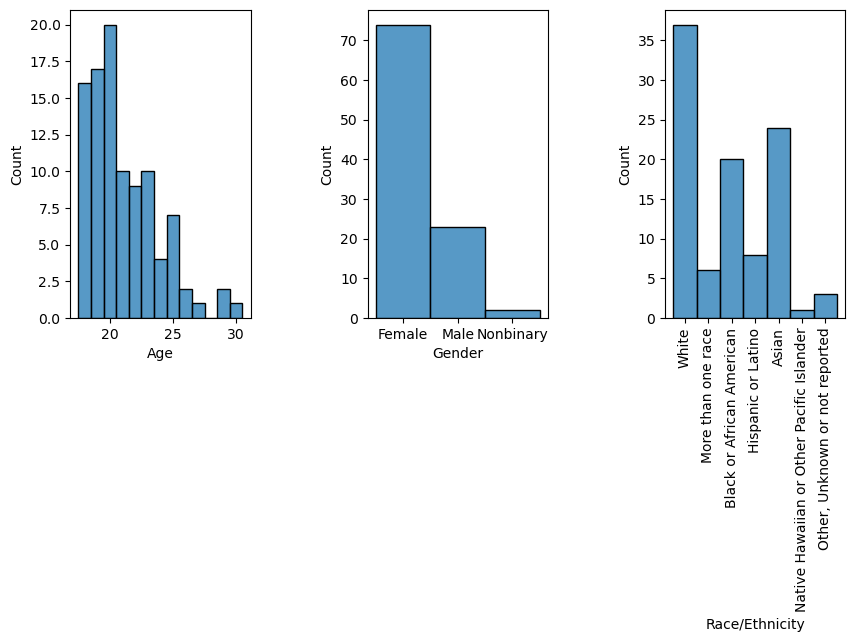

In [51]:
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
sns.histplot(demo_info_fltr, x='Age', legend=False)

plt.subplot(1, 3, 2)
ax = sns.histplot(demo_info_fltr, x='Gender')

plt.subplot(1, 3, 3)
ax = sns.histplot(demo_info_fltr, x='Race/Ethnicity')
ax.tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(wspace = 0.65)

## Export General List

In [56]:
fmriprep_demo = demo_info_fltr.loc[participant_list]
fmriprep_demo['participant_id'] = fmriprep_demo.index
fmriprep_demo = fmriprep_demo[['participant_id','Age','Gender','Race/Ethnicity']]

fmriprep_demo.head()

participant_id Age  Gender  \
sub-NET011     sub-NET011  23    Male   
sub-NET012     sub-NET012  25  Female   
sub-NET014     sub-NET014  21    Male   
sub-NET016     sub-NET016  18  Female   
sub-NET017     sub-NET017  22    Male   

                                       Race/Ethnicity  
sub-NET011                                      White  
sub-NET012                                      Asian  
sub-NET014  Native Hawaiian or Other Pacific Islander  
sub-NET016                                      White  
sub-NET017             Other, Unknown or not reported

In [57]:
fmriprep_demo.to_csv(proj_dir+'/participants.tsv', sep='\t', 
                                index=False)

***

# Imaging QC

This section will create a list of participants which have passed the lab based MRI QC protocols. 

## Import QC Data

In [58]:
mriqc_raw.head()

Subject_ID    Run     MaxFD    MeanFD      SdFD  CensorPercent Quality  \
0  sub-NET011     T1       NaN       NaN       NaN            NaN    good   
1  sub-NET011  run-1  0.550616  0.189526  0.079709            0.0    good   
2  sub-NET011  run-2  0.344154  0.171332  0.072854            0.0    good   
3  sub-NET011  run-3  0.446952  0.175449  0.069946            0.0    good   
4  sub-NET011  run-4  0.505895  0.161364  0.073391            0.0    good   

  Cerebellum              Notes  
0        yes                NaN  
1        yes  frontal intensity  
2        yes  frontal intensity  
3        yes  frontal intensity  
4        yes  frontal intensity

Total number of participants:

In [59]:
len(participant_list)

64

## Visualize MRI QC Metadata

### All MRI QC values

<Axes: xlabel='Run,Quality'>

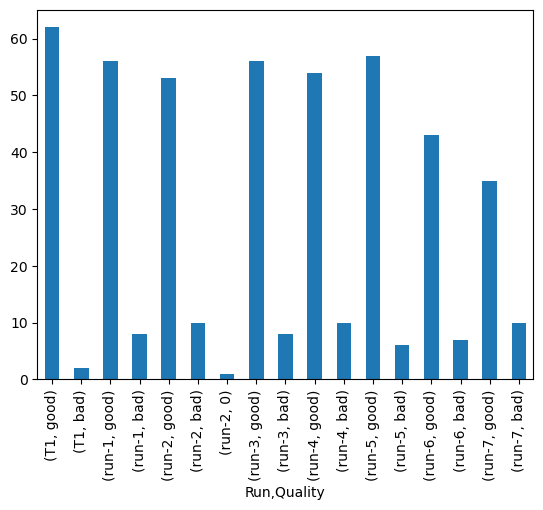

In [60]:
mriqc_raw.groupby('Run')['Quality'].value_counts().plot.bar()

Count the number of participants that are being completly excluded because none of their scan data is usable:

In [61]:
len(mriqc_raw[mriqc_raw['Quality'] != 'good']['Subject_ID'].unique())

25

### Number of good scans

In [62]:
mriqc_melt_good = mriqc_raw[mriqc_raw['Quality'] == 'good']
mriqc_melt_good = mriqc_melt_good.rename(columns={"Subject_ID": "participant_id"})

<Axes: xlabel='Run,Quality'>

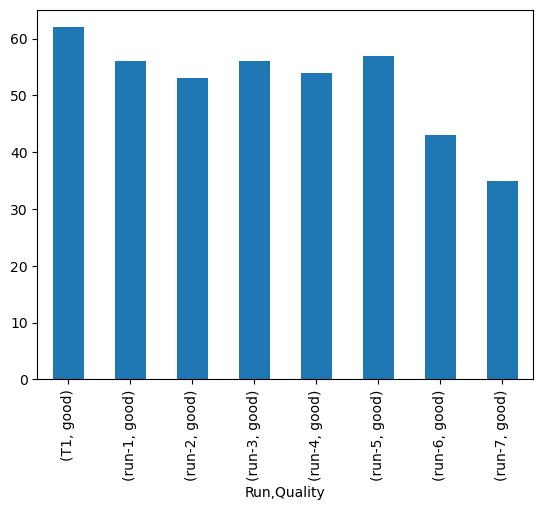

In [63]:
mriqc_melt_good.groupby('Run')['Quality'].value_counts().plot.bar()

### Visualize demographics

In [67]:
fmriprep_demo_qc = fmriprep_demo[fmriprep_demo['participant_id'].isin(mriqc_melt_good['participant_id'].unique())]
fmriprep_demo_qc['Age'] = pd.to_numeric(fmriprep_demo_qc['Age'])

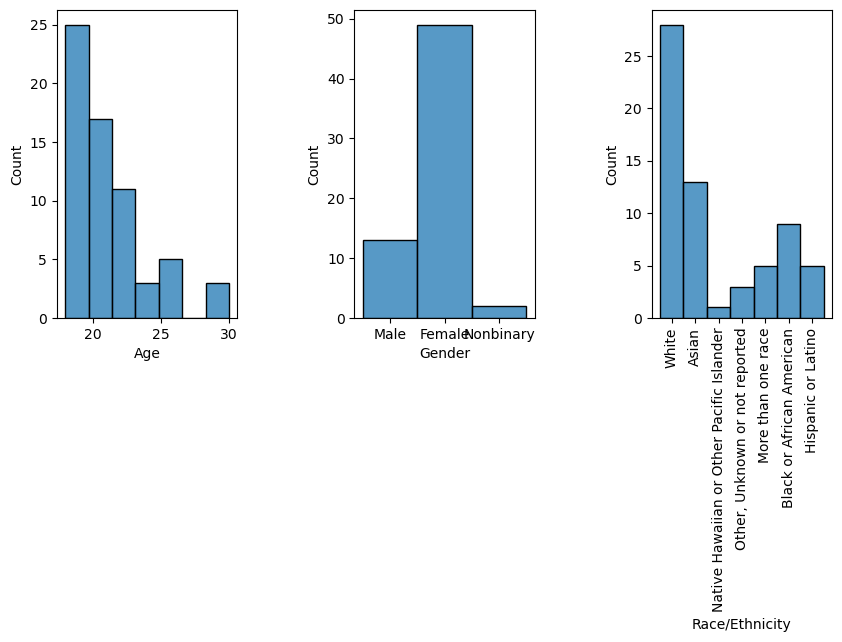

In [68]:
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
sns.histplot(fmriprep_demo_qc, x='Age', legend=False)

plt.subplot(1, 3, 2)
ax = sns.histplot(fmriprep_demo_qc, x='Gender')

plt.subplot(1, 3, 3)
ax = sns.histplot(fmriprep_demo_qc, x='Race/Ethnicity')
ax.tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(wspace = 0.65)

In [70]:
fmriprep_demo_qc.describe()

Age
count  64.000000
mean   20.968750
std     2.905762
min    18.000000
25%    19.000000
50%    20.000000
75%    23.000000
max    30.000000

In [74]:
fmriprep_demo_qc['Gender'].value_counts()

Gender
Female       49
Male         13
Nonbinary     2
Name: count, dtype: int64

In [77]:
fmriprep_demo_qc['Race/Ethnicity'].value_counts() / 64 * 100

Race/Ethnicity
White                                        43.7500
Asian                                        20.3125
Black or African American                    14.0625
More than one race                            7.8125
Hispanic or Latino                            7.8125
Other, Unknown or not reported                4.6875
Native Hawaiian or Other Pacific Islander     1.5625
Name: count, dtype: float64

## Export "Good" MRI QC Participant and Run Info

In [35]:
mriqc_melt_good[['participant_id','Run']].to_csv(proj_dir+'derivatives/participants-qc.csv', 
                                                 index=False)